In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import nltk

# About the dataset

This dataset contains tweets related to US airline companies. Contributors have labeled sentiment of those tweets as positive, negative or neutral. Also, they gave a confidence estimate of sentiment labels. Dataset also includes username of tweet authors and other Twitter related data. In this project, I will concentrate only on extracting sentiment from tweeted text. I will not use airline company or any other info besides tweets themselves.

Dataset available at https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [2]:
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# there is not that much data

data.shape

(14640, 15)

In [4]:
# no missing data for relevant fields: airline_sentiment, airline_sentiment_confidence and text

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
# seeing how much data we keep if we set cutoff value for airline_sentiment_confidence
# we want to keep only data where we can be sure labels are correct

print(data[data['airline_sentiment_confidence']>0.5].shape)
print(data[data['airline_sentiment_confidence']>0.6].shape)
print(data[data['airline_sentiment_confidence']>0.65].shape)
print(data[data['airline_sentiment_confidence']>0.7].shape)


# perhaps, 0.65 is reasonable tradeoff between label confidence and loosing too much data

(14404, 15)
(14402, 15)
(13651, 15)
(10760, 15)


In [6]:
data = data[data['airline_sentiment_confidence']>0.65]
data.shape

(13651, 15)

In [7]:
# keeping only text, label and company name

data = data[['airline_sentiment', 'text', 'airline']]
data.head()

,airline_sentiment,text,airline
0,neutral,@VirginAmerica What @dhepburn said.,Virgin America
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Virgin America
3,negative,@VirginAmerica it's really aggressive to blast...,Virgin America
4,negative,@VirginAmerica and it's a really big bad thing...,Virgin America
5,negative,@VirginAmerica seriously would pay $30 a fligh...,Virgin America


In [8]:
# labels value counts and prpoprtions

print(data['airline_sentiment'].value_counts())
print('\n\n', data['airline_sentiment'].value_counts()/len(data))

negative    8787
neutral     2700
positive    2164
Name: airline_sentiment, dtype: int64


 negative    0.643689
neutral     0.197788
positive    0.158523
Name: airline_sentiment, dtype: float64


In [9]:
# airline value counts

data['airline'].value_counts()

United            3555
US Airways        2763
American          2615
Southwest         2223
Delta             2030
Virgin America     465
Name: airline, dtype: int64

<Figure size 1080x216 with 0 Axes>

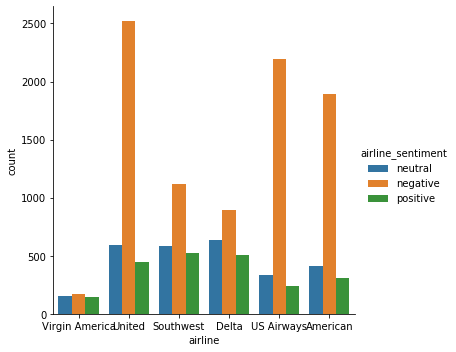

In [10]:
# reviews per airline

import seaborn as sns

plt.figure(figsize = (15,3))
sns.catplot(x = 'airline', hue = 'airline_sentiment', data = data, kind = 'count')
plt.show()

We can se that airline companies differ by quality of their reviews. Also, all tweets contain company username - that's how they are labeled by company in the first place. So, if we kept these usernames as word features, they would influence our model in unwanted way: because US Airways for example has many more bad reviews than good or neutral, our model would learn to classify tweets containing US Airways username (@USAirways) as negative, regardless of their content.

In [11]:
# labels to numbers

labels = data['airline_sentiment'].values.copy()

labels[labels=='negative'] = 0
labels[labels=='neutral'] = 1
labels[labels=='positive'] = 2

labels = labels.astype(np.int64)

# sanity check

pd.Series(labels).value_counts()

0    8787
1    2700
2    2164
dtype: int64

# Text preprocessing

In [12]:
# printing 20 random tweets

rand = np.random.randint(0,len(data), 20)
for i in rand:
    print(data.iloc[i]['text'])

@AmericanAir called executive platinum desk and got a TWO HOUR call back time... 2.5 hrs Late Flightr still no call and still stuck in Chicago
@JetBlue Can you take @Cosmopolitan off your blacklist... trying to work :(
@SouthwestAir it's pretty stupid and I probably won't fly it again. Plus hearing nightmare stories of overbooked flights.
@SouthwestAir alas, it was pretty full so we had to entertain ourselves with witty repartee ...
@united please tell CLT flight 4232 needs a gate. Waiting now for 15 mins.
@SouthwestAir App Updated With #Passbook Support http://t.co/WrWqrUblPs via @ubergizmo
@JetBlue I do not want to deal with your customer service agents with no practical knowledge.Provide me with a direct contact.
@USAirways From here on out when I can at all I'm flying @Delta. Since when is a plane getting stuck in a drift for 2 hours a weather issue?
@AmericanAir 30 minutes flight from OKC and then make us wait, 30 minutes cause the gate isn't empty.  #epicfail #poorplanning
@South

In [13]:
# keeping only np array

texts = data['text'].values.copy()

In [14]:
# first keeping only alfanumeric and ascii chars - to drop all smileys etc
# dropping all of the special chars except # for hashtag - hashtags could have some meaningful info
# dropping links
# lowercasing everything


# first, replacing all multiple whitespaces with single whitespace
# also, removing all " and ''

import re

whitespace_cleaner = re.compile(r'\s+')
quot1_cleaner = re.compile("""'""")
quot2_cleaner = re.compile('''"''')
for i in range(len(texts)):
    texts[i] = whitespace_cleaner.sub(' ', texts[i]).strip()
    texts[i] = quot1_cleaner.sub('', texts[i])
    texts[i] = quot1_cleaner.sub('', texts[i])
    

texts_prep = []
filters =['!','''"''', '$', '%' ,'&', '(', ')', '*', '.', ',', '+', '-', '/',':',';','<','=','>',
          '?','[',']','^','_','`','{','|','}','~','\t','\n', '@']

for text in texts:
    as_list = text.split(' ')
    to_add = []
    for item in as_list:
        proc = []
        if item.isalnum() or item.isascii():
            if item.startswith('http') == False and item.startswith('@') == False:
                x = list(item)
                for i in x:
                    if i not in filters:
                        proc.append(i)
                if '' in proc:
                    proc.remove('')
                to_add.append(''.join(proc).lower())
                
    texts_prep.append(' '.join(to_add).strip())
                
texts_prep = np.array(texts_prep)

In [15]:
texts.shape, texts_prep.shape

((13651,), (13651,))

In [16]:
# printing  20 random tweets  before and after cleaning

rand = np.random.randint(0,len(texts), 20)

for i in rand:
    print('ORIGINAL:   ', texts[i], '\n', 'PROCESSED:   ', texts_prep[i], '\n\n\n')

ORIGINAL:    @USAirways what is policy on changing flight to different dates once your flight has been delayed? 
 PROCESSED:    what is policy on changing flight to different dates once your flight has been delayed 



ORIGINAL:    @united already did that at the airport and 12 hrs Late Flightr its still not here! you guys are really killing me today. trying to stay positive.. 
 PROCESSED:    already did that at the airport and 12 hrs late flightr its still not here you guys are really killing me today trying to stay positive 



ORIGINAL:    @USAirways when will FLT 445 get a gate at DEN? Over 20 minutes waiting with no information. 
 PROCESSED:    when will flt 445 get a gate at den over 20 minutes waiting with no information 



ORIGINAL:    @AmericanAir wow thats helpful. 
 PROCESSED:    wow thats helpful 



ORIGINAL:    @united more people stranded cause you suck. Better yet, you weasel out of Flight Booking Problems rooms for people claiming weather http://t.co/Flcnnn2USD 
 PROC

### Lemmatization

Next step is lemmatization of text. Lemmatization keeps lemma, or root of the word, but also ensuring that root belongs to the language (unlike stemming, where root does not have to be a real word in language). This way, various forms of same word (for example verbs playing, played) will be reduced to same lemma - play. This will reduce number of tokens used in model by combining words with same meaning (for example when play is verb) into single token.

Lemmatization requires POS (part of speech tagging) of words, in order to be able to reduce words to appropriate lemma. POS identifies words as nouns, verbs, adjectives etc. NLTK also contains POS tagging algorithm.

However, NLTK's WordNetLemmatized can't use all of the pos tags, it has only options for nouns, verbs, adjectives and adverbs. Also, these are words that come in many forms, while most other words are more or less unmutable. So, I will apply lemmatization to these kinds of words, and not to others.

In [17]:
# POS tagging all words in tweets, and keeping tags only for nouns, verbs, adjectives and adverbs

texts_tagged = []

for text in texts_prep:
    
    tagged_final = []
    
    as_list = text.split(' ')
    as_list = np.array(as_list)
    # some '' are stil left in list, cleaning them with numpy where
    where = np.where(as_list == '')
    as_list = np.delete(as_list, where)
    
    tagged = nltk.pos_tag(as_list)
    
    for item in tagged:
        if item[1].startswith('N'):
            tagged_final.append((item[0],'n'))
        elif item[1].startswith('V'):
            tagged_final.append((item[0],'v'))
        elif item[1].startswith('J'):
            tagged_final.append((item[0],'a'))
        elif item[1].startswith('R'):
            tagged_final.append((item[0],'r'))
        else:
            tagged_final.append((item[0], None))
    
    texts_tagged.append(tagged_final)

texts_tagged = np.array(texts_tagged)

In [18]:
texts_tagged.shape

(13651,)

In [19]:
texts_tagged[1]

[('i', 'n'),
 ('didnt', 'v'),
 ('today', 'n'),
 ('must', None),
 ('mean', 'v'),
 ('i', 'n'),
 ('need', 'v'),
 ('to', None),
 ('take', 'v'),
 ('another', None),
 ('trip', 'n')]

In [20]:
# now, lemmatizing words

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

texts_lemmed = []

for text in texts_tagged:
    
    to_add = []
    
    for i,j in text:
        if j == None:
            to_add.append(i)
        else:
            to_add.append(lem.lemmatize(i, pos = j))
    
    texts_lemmed.append(' '.join(to_add))
    
texts_lemmed = np.array(texts_lemmed)

In [21]:
# printing  20 random original and finally preprocessed

rand = np.random.randint(0,len(texts), 20)

for i in rand:
    print('ORIGINAL:   ', texts[i], '\n', 'PROCESSED:   ', texts_lemmed[i], '\n\n\n')

ORIGINAL:    @USAirways whats going on with US Airways flight 805? Why diverted to Charlotte? 
 PROCESSED:    whats go on with us airway flight 805 why divert to charlotte 



ORIGINAL:    @united hoping to get out earlier than 2/23 (only phone option) or assistance with hotel. 
 PROCESSED:    hop to get out early than 223 only phone option or assistance with hotel 



ORIGINAL:    @SouthwestAir #DestinationDragons Any word on winners of contest? Any chance for tix for the Provo DestinationDragons show? Fingers Crossed! 
 PROCESSED:    #destinationdragons any word on winner of contest any chance for tix for the provo destinationdragons show finger cross 



ORIGINAL:    @united you cant say the flight is pulled in and departs in 2 mins if boarding hasnt even started! http://t.co/2IKbP8gxWi 
 PROCESSED:    you cant say the flight be pull in and departs in 2 min if boarding hasnt even start 



ORIGINAL:    @usairways Ive been on hold for approaching 2 hrs for an issue when I changed my 

# Creating vocabulary

In [22]:
# analyzing frequency of individidual words, to determine how many of them to keep as tokens

# first, we have to add all words to single list, to count their occurences

all_words = []

for i in texts_lemmed:
    x = i.split(' ')
    for j in x:
        all_words.append(j)

In [23]:
# we have 223800 words total

len(all_words)

223800

In [24]:
# we have 12954 unique words

np.unique(all_words).shape

(12954,)

In [25]:
freq_dist = nltk.FreqDist(all_words)

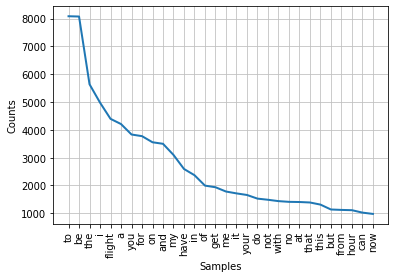

In [26]:
# 30 most common words

freq_dist.plot(30)

In [27]:
# keeping only words which show up 10 or more times in tweets as tokens, discarding rest

tokens = {k:v for k,v in freq_dist.items() if v >= 10}

In [28]:
# so, we end up with 1599 words as tokens

len(tokens.keys())

1599

In [29]:
# now, converting each of words to be kept to its index - integer replacing its string

# bit of cheating - using keras tokenizer. keras is much more user friendly library than torch :) 

from tensorflow.keras.preprocessing.text import Tokenizer

# using 1599 most frequent words (tokens start from 1), and no filters since text is already filtered
tok = Tokenizer(num_words = 1600, filters = '')

tok.fit_on_texts(texts_lemmed)

texts_tokenized = tok.texts_to_sequences(texts_lemmed)

In [30]:
# some tweets are reduced to 0 words after tokenizing (dropping out al non token words)
# some others have just 1 word
# removing those from both inputs and labels
# i.e. tweets need to have at least 2 kept words to be used in model

text_lens = []

for i in texts_tokenized:
    text_lens.append(len(i))
    
text_lens = np.array(text_lens)
filter_short = np.where(text_lens>1)

texts_tokenized_filtered = np.array(texts_tokenized)[filter_short]
labels_filtered = labels[filter_short]

In [31]:
texts_tokenized_filtered.shape, labels_filtered.shape

((13447,), (13447,))

In [32]:
# making each tweet torch tensor, for padding

texts_tokenized_torch = []

for i in texts_tokenized_filtered:
    texts_tokenized_torch.append(torch.tensor(i))

In [33]:
texts_tokenized_torch

[tensor([58, 82]),
 tensor([  4, 189,  99, 752, 328,   4,  57,   1,  81, 147, 170]),
 tensor([  65,  131,    1,  906,   13,   18, 1040,   61,   52,   12,  461]),
 tensor([ 10,  65,   6, 131, 374,  90, 262,  80,  17]),
 tensor([411,  77, 139, 269,   6,   5,   8,  83,  24, 189,  12,  25, 980,  65,
         131,   3, 117,  90, 262,  80,  47]),
 tensor([ 166, 1274,  287,   35,    4,   47,   25,   44,  450]),
 tensor([ 148,    4,   30,    4,   19, 1210]),
 tensor([ 17,   2, 468,  10, 243,  33,  28, 227, 203, 172, 100,   1,  16]),
 tensor([  19,    7,   96,   24,    2,    3,  501,  412,   14, 1275, 1503]),
 tensor([   4, 1158,  595,   41,  173,  100,  155, 1210]),
 tensor([  25,    2,  508,    6,  114,  329,  202,  180,   80,   11,  555,  170,
            1,   61,    4,  334,  130,   44,    9,   11,  330,  170,  237, 1159]),
 tensor([378,   2,  69, 876]),
 tensor([  41,    8,   11,  156,  687,  715,    5,  288,    1,  716,  115,  907,
          228,   26,  114,  262,   80,  847, 1041]),
 ten

In [34]:
# we can lookup indices and words here, they are sorted by frequency

tok.index_word

{1: 'to',
 2: 'be',
 3: 'the',
 4: 'i',
 5: 'flight',
 6: 'a',
 7: 'you',
 8: 'for',
 9: 'on',
 10: 'and',
 11: 'my',
 12: 'have',
 13: 'in',
 14: 'of',
 15: 'get',
 16: 'me',
 17: 'it',
 18: 'your',
 19: 'do',
 20: 'not',
 21: 'with',
 22: 'no',
 23: 'at',
 24: 'that',
 25: 'this',
 26: 'but',
 27: 'from',
 28: 'hour',
 29: 'can',
 30: 'now',
 31: 'we',
 32: 'service',
 33: 'an',
 34: 'thanks',
 35: 'time',
 36: 'customer',
 37: 'just',
 38: 'cancel',
 39: 'help',
 40: 'delay',
 41: 'so',
 42: 'call',
 43: 'wait',
 44: 'go',
 45: 'will',
 46: 'bag',
 47: 'fly',
 48: 'hold',
 49: 'up',
 50: 'plane',
 51: 'im',
 52: 'they',
 53: 'out',
 54: 'our',
 55: 'make',
 56: 'us',
 57: 'need',
 58: 'what',
 59: '2',
 60: 'when',
 61: 'amp',
 62: 'how',
 63: 'thank',
 64: 'all',
 65: 'its',
 66: 'why',
 67: 'if',
 68: 'cant',
 69: 'still',
 70: 'try',
 71: 'one',
 72: 'there',
 73: 'day',
 74: 'please',
 75: 'airline',
 76: 'gate',
 77: 'would',
 78: 'back',
 79: 'flightled',
 80: 'about',
 81: 't

# NN modeling

In [35]:
# tweet texts vary in length (no of words). trainloader requires that all data have same shape
# so, padding with zeros, until all tweets get length of longest tweet

texts_tokenized_torch = nn.utils.rnn.pad_sequence(texts_tokenized_torch, batch_first=True, 
                                                  padding_value=0)

In [36]:
texts_tokenized_torch

tensor([[ 58,  82,   0,  ...,   0,   0,   0],
        [  4, 189,  99,  ...,   0,   0,   0],
        [ 65, 131,   1,  ...,   0,   0,   0],
        ...,
        [ 74, 429, 403,  ...,   0,   0,   0],
        [  7,  12,  11,  ...,   0,   0,   0],
        [ 31,  12, 413,  ...,   5,   0,   0]])

In [37]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts_tokenized_torch, labels_filtered, test_size = 0.2, random_state = 42)

In [38]:
# making data loaders
# batch size of 300 - roughly 3% of dataset

trainloader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=300, shuffle=False)

testloader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=300, shuffle=False)

In [39]:
GPU = torch.device('cuda: 0')
CPU = torch.device('cpu')

In [49]:
#### Neural Network

import torch.nn as nn
import torch.nn.functional as F


class NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(1600, 128, padding_idx=0)
        self.lstm = nn.LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True, dropout=0.2)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        
        # needed for packing sequences
        # finds out how many words (non padding) each input has - discards zeros
        seq_lens = []
        for i in x:
            xx = i.to(CPU).numpy()
            where = np.where(xx!=0)[0]
            seq_lens.append(len(where))
            
        x = self.embedding(x)
        # packing padded sequences to ensure LSTM skips zeros
        # also, packing speeds training up
        x = nn.utils.rnn.pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False)
        # keeping only last hidden state
        _, x = self.lstm(x)
        # keeping results from last of 3 lstm layers
        # since it is bidirectional, keeping both outputs
        # stacking them together, to have 256 dimensions in final lstm output
        x = x[0][0:2]
        x = torch.cat((x[0],x[1]), dim = 1)
        # fc layers
        x = F.leaky_relu(self.dropout(self.fc1(x)), 0.2)
        x = F.leaky_relu(self.dropout(self.fc2(x)), 0.2)
        x = F.log_softmax(self.fc3(x),1)
        
        return x


model = NN()

model.to(GPU)

NN(
  (embedding): Embedding(1600, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [40]:
# proportions of class instances - to be used as weights in training

class_weights = 1 - data['airline_sentiment'].value_counts()/len(data)

class_weights = torch.Tensor(class_weights.values).to(GPU)

class_weights

tensor([0.3563, 0.8022, 0.8415], device='cuda:0')

In [50]:
criterion = nn.NLLLoss(weight=class_weights)

# adding some L2 regularization to prevent overfitting 

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)

In [42]:
# defining training loop with early stopping if test loss does not improve after given no of epochs

def train_neural_network(model, trainloader, testloader, epochs, earlystopping_epochs):

    import time

    time1 = time.time()
    # this is where test losses are saved, to keep track of them and perform early stopping
    all_test_losses = []


    for epoch in range(epochs):

        # lists to store accuracy and loss in each training step in single epoch
        train_loss = []
        train_accuracy = []

        # steps in each epoch
        for inputs, labels in trainloader:
            
            # NN training
            time2 = time.time()
            inputs, labels = inputs.to(GPU), labels.to(GPU)
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # saving train loss of each step
            train_loss.append(float(loss))
            
            # calculating train accuracy in each step
            preds = outputs.detach().to(CPU).numpy()
            # converting model outputs to class labels (integers)
            preds_class = []
            for i in preds:
                where = np.where(i==i.max())[0][0]
                preds_class.append(where)
            labels = labels.to(CPU).numpy()
            preds_class = np.array(preds_class)
            equals = preds_class == labels
            # saving train_accuracy of each step
            train_accuracy.append(np.mean(equals))


        
        # computing train accuracy and loss
        with torch.no_grad():
            test_loss = [] 
            test_accuracy = []
            
            for inputs, labels in testloader:
                inputs = inputs.to(GPU)
                labels = labels.to(GPU)   


                # predictions, and test loss
                preds = model.forward(inputs)
                loss = float(criterion(preds, labels))
                test_loss.append(loss)
            
                # making label array out of predictions
                # and computing test accuracy for each step
                preds = preds.to(CPU).numpy()
                preds_class = []
                for i in preds:
                    where = np.where(i==i.max())[0][0]
                    preds_class.append(where)
                labels = labels.to(CPU).numpy()         
                equals = preds_class == labels
                test_accuracy.append(np.mean(equals))
            
            # saving testing loss of each epoch
            all_test_losses.append(np.mean(test_loss))
                
            # minimum test loss
            min_test_loss = min(all_test_losses)
            # keeping weights after current epochs if its test loss is new minimum
            if len(all_test_losses)>1:
                prev_min_test_loss = min(all_test_losses[:-1])
                if min_test_loss < prev_min_test_loss:
                    weights = model.state_dict()
                    
            # index of minimum test loss - actually index of epoch in which that loss is achieved
            min_test_loss_idx = all_test_losses.index(min_test_loss)
                
        
        # early stopping - if min test loss has not decreased for given number of epochs
        # stop training
        # and load weights from best epoch
        if (len(all_test_losses)-1) - min_test_loss_idx > earlystopping_epochs:       
            print(f'Epoch {epoch+1}/{epochs}.. '
                          f'Train loss: {np.round(np.mean(train_loss),4)}.. '
                          f'Test loss: {np.round(np.mean(test_loss),4)}.. '
                          f'Train accuracy: {np.round(np.mean(train_accuracy),3)}.. '
                          f'Test accuracy: {np.round(np.mean(test_accuracy),3)}.. '
                          f'Epoch time: {np.round(time.time()-time2,2)}'
                          f'\n\n Early stopping after {epoch+1} epochs. '
                          f'Weights from epoch {min_test_loss_idx+1} set to model.')
            
            model.load_state_dict(weights)
            
            break
            


       # printing stats of each epoch
        print(f'Epoch {epoch+1}/{epochs}.. '
                      f'Train loss: {np.round(np.mean(train_loss),4)}.. '
                      f'Test loss: {np.round(np.mean(test_loss),4)}.. '
                      f'Train accuracy: {np.round(np.mean(train_accuracy),3)}.. '
                      f'Test accuracy: {np.round(np.mean(test_accuracy),3)}.. '
                      f'Epoch time: {np.round(time.time()-time2,2)}')

    # finally, printing total training time
    print(f'\n Total time: {np.round(time.time()-time1,1)} seconds '
          f'({np.round((time.time()-time1)/60,2)} minutes)')

In [115]:
# early stopping set to 10 epochs

train_neural_network(model=model, trainloader=trainloader, testloader=testloader,
                    epochs=500, earlystopping_epochs=15)

Epoch 1/500.. Train loss: 1.0776.. Test loss: 1.0579.. Train accuracy: 0.638.. Test accuracy: 0.653.. Epoch time: 0.23
Epoch 2/500.. Train loss: 1.0317.. Test loss: 1.0101.. Train accuracy: 0.656.. Test accuracy: 0.681.. Epoch time: 0.23
Epoch 3/500.. Train loss: 0.9786.. Test loss: 0.9396.. Train accuracy: 0.685.. Test accuracy: 0.684.. Epoch time: 0.23
Epoch 4/500.. Train loss: 0.9116.. Test loss: 0.9119.. Train accuracy: 0.695.. Test accuracy: 0.688.. Epoch time: 0.23
Epoch 5/500.. Train loss: 0.8852.. Test loss: 0.9002.. Train accuracy: 0.701.. Test accuracy: 0.697.. Epoch time: 0.23
Epoch 6/500.. Train loss: 0.8559.. Test loss: 0.8704.. Train accuracy: 0.711.. Test accuracy: 0.7.. Epoch time: 0.23
Epoch 7/500.. Train loss: 0.8164.. Test loss: 0.8308.. Train accuracy: 0.716.. Test accuracy: 0.711.. Epoch time: 0.23
Epoch 8/500.. Train loss: 0.7769.. Test loss: 0.8002.. Train accuracy: 0.725.. Test accuracy: 0.712.. Epoch time: 0.23
Epoch 9/500.. Train loss: 0.754.. Test loss: 0.792

In [116]:
# evaluating scores

# train predictions

preds_train = []
out_train = model.forward(torch.tensor(X_train).to(GPU)).to(CPU).detach().numpy()

for i in out_train:
    where = np.where(i == i.max())[0][0]
    preds_train.append(where)

preds_train = np.array(preds_train)
preds_train.shape

/usr/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(10757,)

In [117]:
# test predictions 

preds_test = []
out_test = model.forward(torch.tensor(X_test).to(GPU)).to(CPU).detach().numpy()

for i in out_test:
    where = np.where(i == i.max())[0][0]
    preds_test.append(where)

preds_test = np.array(preds_test)
preds_test.shape

/usr/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


(2690,)

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prf

In [118]:
print('train accuracy: ', accuracy_score(y_train, preds_train))
print('test accuracy: ', accuracy_score(y_test, preds_test))

train accuracy:  0.8748721762573208
test accuracy:  0.774721189591078


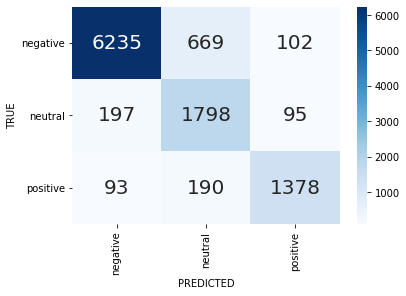

In [119]:
# train cm

sns.heatmap(confusion_matrix(y_train, preds_train), annot=True, fmt='g',
            annot_kws={'size':20}, cmap='Blues')
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5,2.5],
           ['negative', 'neutral', 'positive'],
          rotation = 90)
plt.yticks([0.5,1.5,2.5],
           ['negative', 'neutral', 'positive'],
          rotation = 0)
plt.show()

In [120]:
# train scores

scores = prf(y_train, preds_train)

df = pd.DataFrame(np.empty((3,4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores[0])):
    df.iloc[i,:] = [x[i] for x in scores]
df.index = ['negative', 'neutral', 'positive']
df

,precision,recall,f1,support
negative,0.955556,0.889951,0.921587,7006.0
neutral,0.676703,0.860287,0.757531,2090.0
positive,0.874921,0.829621,0.851669,1661.0


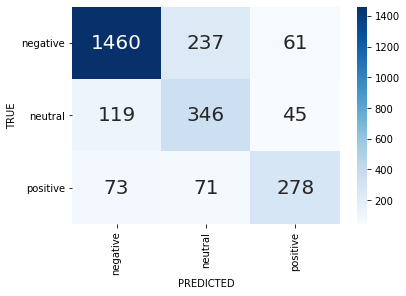

In [121]:
# test cm

sns.heatmap(confusion_matrix(y_test, preds_test), annot=True, fmt='g', 
            annot_kws={'size':20}, cmap = 'Blues')
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5,2.5],
           ['negative', 'neutral', 'positive'],
          rotation = 90)
plt.yticks([0.5,1.5,2.5],
           ['negative', 'neutral', 'positive'],
          rotation = 0)
plt.show()

In [122]:
# test scores

scores = prf(y_test, preds_test)

df = pd.DataFrame(np.empty((3,4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores[0])):
    df.iloc[i,:] = [x[i] for x in scores]
df.index = ['negative', 'neutral', 'positive']
df

,precision,recall,f1,support
negative,0.883777,0.830489,0.856305,1758.0
neutral,0.529052,0.678431,0.594502,510.0
positive,0.723958,0.658768,0.689826,422.0


In [123]:
# saving model

torch.save(model.state_dict(), 
           '/home/ksaver/Desktop/faks/deep learning/projekt/tweets_model_weights.pth')

### Comment on scores

Model does overfit even though both dropout and regularization have been added. However, greater regularization and dropout would lead to model underfitting greatly.

In terms of accuracy score, model has mostly similar scores as other models available on Kaggle. Best of them reach 80% accuracy on validation data. However, this model beats them in terms of F1 score. This means it does better at classifying underrepresented classes (neutral and positive reviews) correctly.

# Trying out some of the actual tweets and seeing how they perform

In [174]:
rand = np.random.randint(0,len(tweets), 20)

label_dict = {0: 'negative',
              1: 'neutral',
              2: 'positive'}

for i in rand:
    
    tweet = texts[filter_short][i]
    
    tweet_processed = texts_tokenized_torch[i]
    
    label = labels_filtered[i]
    
    pred = model(tweet_processed.reshape(1,31).to(GPU))
    
    pred = pred.detach().to(CPU).numpy()
    
    pred = np.where(pred == pred.max())[0][0]
    
    
    print('Original tweet: ', tweet, '\n true sentiment: ', label_dict[label],
          '\t predicted sentiment: ', label_dict[pred], '\n\n')

Original tweet:  @united UA1023 sitting on Tarmac at ORD when there are visibly gates open. Reassign our gate. 
 true sentiment:  negative 	 predicted sentiment:  negative 


Original tweet:  @united Apart from being on hold for over 2 hours and having talked to 5 people and the problem still not resolved! 
 true sentiment:  negative 	 predicted sentiment:  negative 


Original tweet:  @united I havent booked yet, Im asking before I book 
 true sentiment:  neutral 	 predicted sentiment:  negative 


Original tweet:  @united are there any upgrades avail to get us all on the same flight 
 true sentiment:  neutral 	 predicted sentiment:  negative 


Original tweet:  @united just called and did it. Should have earlier because Im being sent to DCA first and THEN to pvd. We may rent a car instead. 
 true sentiment:  neutral 	 predicted sentiment:  negative 


Original tweet:  @united Well, to the degree that he could... Just to know, after this experience Im Cancelled Flighting my miles card